# VCLOD Test for Coefficient 3

This script performs the main VCLOD test for this thesis with a specific diffusion coefficient. We investigate the energy error of the VCLOD dependent on the updated correctors. For this purpose, we update every corrector individually and compare it to the reference solution. This enables a good comparison between percentages. We desire to yield a fast decrease of the energy error of the VCLOD method since, due to the error indicator, we sort and update the element correctors in terms of the effect that comes with the perturbation.    

In [2]:
import os
import sys
import numpy as np
import scipy.sparse as sparse
import random
import csv

%matplotlib notebook
import matplotlib.pyplot as plt
from visualize import drawCoefficient
from data import * 

from gridlod import interp, coef, util, fem, world, linalg, femsolver
import pg_rand, femsolverCoarse, buildcoef2d
from gridlod.world import World

## Result function

The 'result' function investigates the VCLOD for each percentage. The reference solution is computed by a standard FEM on the fine mesh. We compute the 'worst solution' that represents zero percentage updating and clearly has no computational cost at all. Afterwards, we compute the error indicator for the given patch size $k=4$ and use every value gradually. Furthermore we store the resulting energy error for the VCLOD as well as the optimal energy error that results from 100 percentage updating. Once again, we take advantage of the 'gridlod' module in order to compute the required matrices.   

In [3]:
def result(pglod, world, A, R, f, k, String):
    print "-------------- " + String + " ---------------" 
    NWorldFine = world.NWorldFine
    NWorldCoarse = world.NWorldCoarse
    NCoarseElement = world.NCoarseElement
    
    boundaryConditions = world.boundaryConditions
    NpFine = np.prod(NWorldFine+1)
    NpCoarse = np.prod(NWorldCoarse+1)
        
    # new Coefficient
    ANew = R.flatten()
    Anew = coef.coefficientFine(NWorldCoarse, NCoarseElement, ANew)
    
    # reference solution
    f_fine = np.ones(NpFine)
    uFineFem, AFine, MFine = femsolver.solveFine(world, ANew, f_fine, None, boundaryConditions)
    
    # worst solution
    KFull = pglod.assembleMsStiffnessMatrix()
    MFull = fem.assemblePatchMatrix(NWorldCoarse, world.MLocCoarse)
    free  = util.interiorpIndexMap(NWorldCoarse)                                 
    
    bFull = MFull*f
    KFree = KFull[free][:,free]
    bFree = bFull[free]

    xFree = sparse.linalg.spsolve(KFree, bFree)
    
    basis = fem.assembleProlongationMatrix(NWorldCoarse, NCoarseElement)
    
    basisCorrectors = pglod.assembleBasisCorrectors()
    modifiedBasis = basis - basisCorrectors
    
    xFull = np.zeros(NpCoarse)
    xFull[free] = xFree
    uCoarse = xFull
    uLodFine = modifiedBasis*xFull
    
    uLodFineWorst = uLodFine
    
    # energy error
    errorworst = np.sqrt(np.dot(uFineFem - uLodFineWorst, AFine*(uFineFem - uLodFineWorst)))
    
    # tolerance = 0 
    vis, eps = pglod.updateCorrectors(Anew, 0, f, 1, clearFineQuantities=False, Computing=False)
    
    PotentialCorrectors = np.sum(vis)
    elemente = np.arange(np.prod(NWorldCoarse))
            
    # identify tolerances
    epsnozero = filter(lambda x: x!=0, eps)
    
    assert(np.size(epsnozero) != 0)
    
    mini = np.min(epsnozero)
    minilog = int(round(np.log10(mini)-0.49))
    epsnozero.append(10**(minilog))
    ToleranceListcomplete = []
    for i in range(0,int(np.size(epsnozero))):
        ToleranceListcomplete.append(epsnozero[i])

    ToleranceListcomplete.sort()
    ToleranceListcomplete = np.unique(ToleranceListcomplete)

    # with tolerance
    errorplotinfo = []
    tolerancesafe = []
    errorBest = []
    errorWorst = []
    recomputefractionsafe = []
    recomputefraction = 0
    Correctors = 0
    leng = np.size(ToleranceListcomplete)
    for k in range(leng-1,-1,-1):
        tol = ToleranceListcomplete[k]
        print " --- "+ str(-k+leng) + "/" + str(leng)+ " --- Tolerance: " + str(round(tol,5)) + " in "+ String +" ---- ", 
        vistol = pglod.updateCorrectors(Anew, tol, f, clearFineQuantities=False, Testing=True)
        
        Correctors += np.sum(vistol)
        
        recomputefraction += float(np.sum(vistol))/PotentialCorrectors * 100
        recomputefractionsafe.append(recomputefraction)
        
        KFull = pglod.assembleMsStiffnessMatrix()
        MFull = fem.assemblePatchMatrix(NWorldCoarse, world.MLocCoarse)
        free  = util.interiorpIndexMap(NWorldCoarse)                                 

        bFull = MFull*f
        KFree = KFull[free][:,free]
        bFree = bFull[free]

        xFree = sparse.linalg.spsolve(KFree, bFree)
        basis = fem.assembleProlongationMatrix(NWorldCoarse, NCoarseElement)

        basisCorrectors = pglod.assembleBasisCorrectors()

        modifiedBasis = basis - basisCorrectors

        xFull = np.zeros(NpCoarse)
        xFull[free] = xFree
        uCoarse = xFull
        uLodFine = modifiedBasis*xFull
        
        #energy error
        errortol = np.sqrt(np.dot(uFineFem - uLodFine, AFine*(uFineFem - uLodFine)))
        
        errorplotinfo.append(errortol)
        tolerancesafe.append(tol)
    
    # 100% updating
    uLodFinebest = uLodFine
    errorbest = np.sqrt(np.dot(uFineFem - uLodFinebest, AFine*(uFineFem - uLodFinebest)))
    
    for k in range(leng-1,-1,-1):
        errorBest.append(errorbest)
        errorWorst.append(errorworst)

    return vis, eps, PotentialCorrectors, recomputefractionsafe, errorplotinfo, errorWorst, errorBest

## Preparations

We use the same setting as we have already used before containing the 'buildcoef2d' class in order to construct the coefficient. We visualize the coefficient and store the information in an extern folder.

<IPython.core.display.Javascript object>


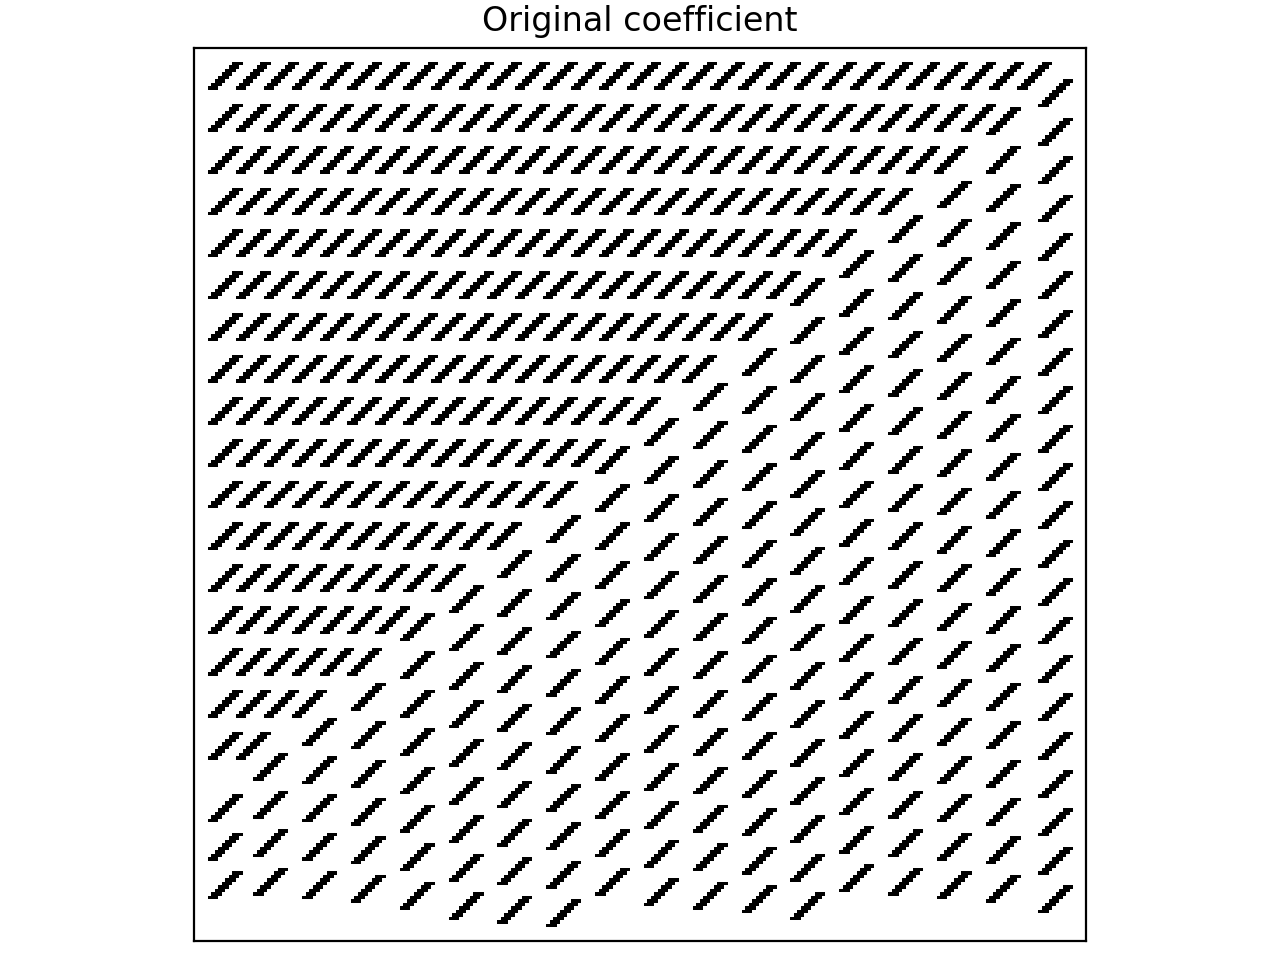

In [5]:
bg = 0.05       #background
val = 1         #values

#fine World
NWorldFine = np.array([256, 256])
NpFine = np.prod(NWorldFine+1)                                                                               

#coarse World
NWorldCoarse = np.array([16,16])
NpCoarse = np.prod(NWorldCoarse+1)

#ratio between Fine and Coarse
NCoarseElement = NWorldFine/NWorldCoarse

boundaryConditions = np.array([[0, 0],
                               [0, 0]])

world = World(NWorldCoarse, NCoarseElement, boundaryConditions)

#righthandside
f = np.ones(NpCoarse)

#Coefficient 3
CoefClass = buildcoef2d.Coefficient2d(NWorldFine, 
                        bg                  = bg, 
                        val                 = val, 
                        length              = 8, 
                        thick               = 2, 
                        space               = 4, 
                        probfactor          = 1, 
                        right               = 0, 
                        down                = 0, 
                        diagr1              = 0, 
                        diagr2              = 0, 
                        diagl1              = 0, 
                        diagl2              = 1, 
                        LenSwitch           = None, 
                        thickSwitch         = None, 
                        equidistant         = None, 
                        ChannelHorizontal   = None, 
                        ChannelVertical     = None,
                        BoundarySpace       = True)

A = CoefClass.BuildCoefficient()
ABase = A.flatten()

ROOT = '../test_data/Coef3'

#safe NworldFine
with open("%s/NWorldFine.txt" % ROOT, 'wb') as csvfile:
    writer = csv.writer(csvfile)
    for val in NWorldFine:
        writer.writerow([val])

#safe NworldCoarse
with open("%s/NWorldCoarse.txt" % ROOT, 'wb') as csvfile:
    writer = csv.writer(csvfile)
    for val in NWorldCoarse:
        writer.writerow([val])

#ABase
with open("%s/OriginalCoeff.txt" % ROOT, 'wb') as csvfile:
    writer = csv.writer(csvfile)
    for val in ABase:
        writer.writerow([val])

#fine-fem
f_fine = np.ones(NpFine)
uFineFem, AFine, MFine = femsolver.solveFine(world, ABase, f_fine, None, boundaryConditions)

#fine solution
with open("%s/finescale.txt" % ROOT, 'wb') as csvfile:
    writer = csv.writer(csvfile)
    for val in uFineFem:
        writer.writerow([val])
        
plt.figure("Original")
drawCoefficient(NWorldFine, ABase,greys=True)
plt.title("Original coefficient")
plt.show()

## Perturbations of the same entries

To keep comparability, we use the 'specific' perturbation function and use a random seed. 

In [6]:
# random seed
random.seed(20)

# decision
valc = np.shape(CoefClass.ShapeRemember)[0]
numbers = []
decision = np.zeros(100)
decision[0] = 1


for i in range(0,valc):
    a = random.sample(decision,1)[0]
    if a == 1:
        numbers.append(i)

value1 = 3
C1 = CoefClass.SpecificValueChange(ratio=value1,
                                    Number = numbers,
                                    probfactor=1,
                                    randomvalue=None,
                                    negative=None,
                                    ShapeRestriction=True,
                                    ShapeWave=None,
                                    ChangeRight=1,
                                    ChangeDown=1,
                                    ChangeDiagr1=1,
                                    ChangeDiagr2=1,
                                    ChangeDiagl1=1,
                                    ChangeDiagl2=1,
                                    Original = True,
                                    NewShapeChange = True)

V = CoefClass.SpecificVanish(Number = numbers,
                                probfactor=1,
                                PartlyVanish=None,
                                ChangeRight=1,
                                ChangeDown=1,
                                ChangeDiagr1=1,
                                ChangeDiagr2=1,
                                ChangeDiagl1=1,
                                ChangeDiagl2=1,
                                Original = True)

M1 = CoefClass.SpecificMove(probfactor=1,
                            Number = numbers,
                            steps=1,
                            randomstep=None,
                            randomDirection=None,
                            ChangeRight=1,
                            ChangeDown=1,
                            ChangeDiagr1=1,
                            ChangeDiagr2=1,
                            ChangeDiagl1=1,
                            ChangeDiagl2=1,
                            Right=1,
                            BottomRight=0,
                            Bottom=0,
                            BottomLeft=0,
                            Left=0,
                            TopLeft=0,
                            Top=0,
                            TopRight=0,
                            Original = True)

## Precomputations

In [7]:
k = 4

NWorldFine = world.NWorldFine
NWorldCoarse = world.NWorldCoarse
NCoarseElement = world.NCoarseElement

boundaryConditions = world.boundaryConditions
NpFine = np.prod(NWorldFine+1)
NpCoarse = np.prod(NWorldCoarse+1)

#interpolant
IPatchGenerator = lambda i, N: interp.L2ProjectionPatchMatrix(i, N, NWorldCoarse, NCoarseElement, boundaryConditions)

#old Coefficient
ABase = A.flatten()
Aold = coef.coefficientFine(NWorldCoarse, NCoarseElement, ABase)

pglod = pg_rand.VcPetrovGalerkinLOD(Aold, world, k, IPatchGenerator, 0)
pglod.originCorrectors(clearFineQuantities=False)

## Change in value

In [8]:
vis, eps, PotentialUpdated, recomputefractionsafe, errorplotinfo, errorworst, errorbest = result(pglod ,world, A, C1, f, k, 'Specific value change' + str(value1))

safeChange(ROOT, C1, vis, eps, PotentialUpdated, recomputefractionsafe, errorplotinfo, errorworst, errorbest)

vis, eps, PotentialUpdated, recomputefractionsafe, errorplotinfo, errorworst, errorbest = result(pglod ,world, A, V, f, k, 'Vanish')

safeVanish(ROOT, V, vis, eps, PotentialUpdated, recomputefractionsafe, errorplotinfo, errorworst, errorbest)

vis, eps, PotentialUpdated, recomputefractionsafe, errorplotinfo, errorworst, errorbest = result(pglod ,world, A, M1, f, k, 'One Step Move')

safeShift(ROOT, M1, vis, eps, PotentialUpdated, recomputefractionsafe, errorplotinfo, errorworst, errorbest)

------------------------------------- Specific value change3 -------------------------------------------
Setting up workers
Done
epsilonT = 0.000288834813011 C
epsilonT = 0.00279324219837 C
epsilonT = 0.00544985166583 C
epsilonT = 0.0101366608271 C
epsilonT = 0.00178019469913 C
epsilonT = 0.000297975261095 C
epsilonT = 0.00088219489201 C
epsilonT = 0.00219969004048 C
epsilonT = 0.00112121724379 C
epsilonT = 0.000644692304235 C
epsilonT = 6.26662999161e-05 C
epsilonT = 1.13754511057e-05 C
epsilonT = 1.29254176995e-05 C
epsilonT = 9.71561316222e-06 C
epsilonT = 1.1843864359e-05 C
epsilonT = 1.50421104773e-05 C
epsilonT = 0.00137094897118 C
epsilonT = 0.0364676895444 C
epsilonT = 0.537554001453 C
epsilonT = 0.0207405280059 C
epsilonT = 0.00231254909211 C
epsilonT = 0.00289414225476 C
epsilonT = 0.0250681097206 C
epsilonT = 0.0149850998957 C
epsilonT = 0.00649909944262 C
epsilonT = 0.000484773854055 C
epsilonT = 6.42900442433e-05 C
epsilonT = 9.01018593277e-05 C
epsilonT = 0.00015005220631

 --- 16/176 --- Tolerance: 0.03337 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 17/176 --- Tolerance: 0.03244 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 18/176 --- Tolerance: 0.03214 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 19/176 --- Tolerance: 0.03128 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 20/176 --- Tolerance: 0.03042 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 21/176 --- Tolerance: 0.0299 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 22/176 --- Tolerance: 0.02731 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 23/176 --- Tolerance: 0.02507 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 24/176 --- Tolerance: 0.02236 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 25/176 --- Tolerance: 0.02217 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 26/176 --- Tolerance: 0.02

 --- 101/176 --- Tolerance: 0.00029 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 102/176 --- Tolerance: 0.00021 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 103/176 --- Tolerance: 0.0002 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 104/176 --- Tolerance: 0.00019 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 105/176 --- Tolerance: 0.00019 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 106/176 --- Tolerance: 0.00018 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 107/176 --- Tolerance: 0.00017 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 108/176 --- Tolerance: 0.00016 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 109/176 --- Tolerance: 0.00015 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 110/176 --- Tolerance: 0.00015 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 111/176 --- Tole

epsilonT = 0.0633372090314 C
epsilonT = 2.29315886807 C
epsilonT = 0.0846769537693 C
epsilonT = 0.00616639282945 C
epsilonT = 0.0204848122368 C
epsilonT = 2.34979440104 C
epsilonT = 2.44070221631 C
epsilonT = 0.0255983156205 C
epsilonT = 0.00177225506438 C
epsilonT = 0.00187845557557 C
epsilonT = 0.00213386779838 C
epsilonT = 0.00327415919364 C
epsilonT = 0.00462513785848 C
epsilonT = 0.0011932588687 C
epsilonT = 0.000132748505739 C
epsilonT = 0.00474154686263 C
epsilonT = 0.0328341627283 C
epsilonT = 0.0142259601938 C
epsilonT = 0.0110039550473 C
epsilonT = 0.00271709419041 C
epsilonT = 0.0292308127208 C
epsilonT = 0.216913764725 C
epsilonT = 0.0861471728515 C
epsilonT = 0.0395428226542 C
epsilonT = 0.00140946840965 C
epsilonT = 0.017262396287 C
epsilonT = 0.0945096900935 C
epsilonT = 0.0773645020729 C
epsilonT = 0.0141675175146 C
epsilonT = 0.00182556085044 C
epsilonT = 0.000144628252074 C
epsilonT = 0.00179882372017 C
epsilonT = 0.00298601728282 C
epsilonT = 0.00312201608674 C
epsil

 --- 33/176 --- Tolerance: 0.03283 in Vanish ----  To be recomputed:  0.390625 %
 --- 34/176 --- Tolerance: 0.02998 in Vanish ----  To be recomputed:  0.390625 %
 --- 35/176 --- Tolerance: 0.02923 in Vanish ----  To be recomputed:  0.390625 %
 --- 36/176 --- Tolerance: 0.02871 in Vanish ----  To be recomputed:  0.390625 %
 --- 37/176 --- Tolerance: 0.0256 in Vanish ----  To be recomputed:  0.390625 %
 --- 38/176 --- Tolerance: 0.02225 in Vanish ----  To be recomputed:  0.390625 %
 --- 39/176 --- Tolerance: 0.02048 in Vanish ----  To be recomputed:  0.390625 %
 --- 40/176 --- Tolerance: 0.01841 in Vanish ----  To be recomputed:  0.390625 %
 --- 41/176 --- Tolerance: 0.01726 in Vanish ----  To be recomputed:  0.390625 %
 --- 42/176 --- Tolerance: 0.01544 in Vanish ----  To be recomputed:  0.390625 %
 --- 43/176 --- Tolerance: 0.01481 in Vanish ----  To be recomputed:  0.390625 %
 --- 44/176 --- Tolerance: 0.01423 in Vanish ----  To be recomputed:  0.390625 %
 --- 45/176 --- Tolerance: 0.

 --- 134/176 --- Tolerance: 0.00011 in Vanish ----  To be recomputed:  0.390625 %
 --- 135/176 --- Tolerance: 0.00011 in Vanish ----  To be recomputed:  0.390625 %
 --- 136/176 --- Tolerance: 0.0001 in Vanish ----  To be recomputed:  0.390625 %
 --- 137/176 --- Tolerance: 0.0001 in Vanish ----  To be recomputed:  0.390625 %
 --- 138/176 --- Tolerance: 0.0001 in Vanish ----  To be recomputed:  0.390625 %
 --- 139/176 --- Tolerance: 9e-05 in Vanish ----  To be recomputed:  0.390625 %
 --- 140/176 --- Tolerance: 9e-05 in Vanish ----  To be recomputed:  0.390625 %
 --- 141/176 --- Tolerance: 9e-05 in Vanish ----  To be recomputed:  0.390625 %
 --- 142/176 --- Tolerance: 8e-05 in Vanish ----  To be recomputed:  0.390625 %
 --- 143/176 --- Tolerance: 7e-05 in Vanish ----  To be recomputed:  0.390625 %
 --- 144/176 --- Tolerance: 6e-05 in Vanish ----  To be recomputed:  0.390625 %
 --- 145/176 --- Tolerance: 6e-05 in Vanish ----  To be recomputed:  0.390625 %
 --- 146/176 --- Tolerance: 6e-05

epsilonT = 0.0 N
epsilonT = 0.0 N
epsilonT = 0.0 N
epsilonT = 0.0 N
epsilonT = 0.0 N
epsilonT = 0.0 N
epsilonT = 0.0 N
epsilonT = 0.0 N
epsilonT = 0.0 N
epsilonT = 0.0 N
epsilonT = 0.0 N
epsilonT = 0.0824160511347 C
epsilonT = 0.0589954629942 C
epsilonT = 0.00615790639158 C
epsilonT = 0.000667263747845 C
epsilonT = 5.84040246534e-05 C
epsilonT = 0.0 N
epsilonT = 0.0 N
epsilonT = 0.0 N
epsilonT = 0.0 N
epsilonT = 0.0 N
epsilonT = 0.0 N
epsilonT = 0.0 N
epsilonT = 0.0 N
epsilonT = 0.0 N
epsilonT = 0.0 N
epsilonT = 0.0 N
epsilonT = 1.920340148 C
epsilonT = 0.142259535787 C
epsilonT = 0.00748562575165 C
epsilonT = 0.000723016907143 C
epsilonT = 5.63915495224e-05 C
epsilonT = 0.0 N
epsilonT = 0.0 N
epsilonT = 0.0 N
epsilonT = 0.0 N
epsilonT = 0.0 N
epsilonT = 0.0 N
epsilonT = 0.0 N
epsilonT = 0.0 N
epsilonT = 0.0 N
epsilonT = 0.0 N
epsilonT = 0.0 N
epsilonT = 0.0817619582724 C
epsilonT = 0.054682848959 C
epsilonT = 0.0038120363394 C
epsilonT = 0.000238259745877 C
epsilonT = 2.80626402186e-0

 --- 73/176 --- Tolerance: 0.00267 in One Step Move ----  To be recomputed:  0.390625 %
 --- 74/176 --- Tolerance: 0.00264 in One Step Move ----  To be recomputed:  0.390625 %
 --- 75/176 --- Tolerance: 0.00226 in One Step Move ----  To be recomputed:  0.390625 %
 --- 76/176 --- Tolerance: 0.0022 in One Step Move ----  To be recomputed:  0.390625 %
 --- 77/176 --- Tolerance: 0.00212 in One Step Move ----  To be recomputed:  0.390625 %
 --- 78/176 --- Tolerance: 0.00211 in One Step Move ----  To be recomputed:  0.390625 %
 --- 79/176 --- Tolerance: 0.00209 in One Step Move ----  To be recomputed:  0.390625 %
 --- 80/176 --- Tolerance: 0.00203 in One Step Move ----  To be recomputed:  0.390625 %
 --- 81/176 --- Tolerance: 0.002 in One Step Move ----  To be recomputed:  0.390625 %
 --- 82/176 --- Tolerance: 0.0018 in One Step Move ----  To be recomputed:  0.390625 %
 --- 83/176 --- Tolerance: 0.00173 in One Step Move ----  To be recomputed:  0.390625 %
 --- 84/176 --- Tolerance: 0.00171 i

 --- 167/176 --- Tolerance: 1e-05 in One Step Move ----  To be recomputed:  0.390625 %
 --- 168/176 --- Tolerance: 1e-05 in One Step Move ----  To be recomputed:  0.390625 %
 --- 169/176 --- Tolerance: 1e-05 in One Step Move ----  To be recomputed:  0.390625 %
 --- 170/176 --- Tolerance: 1e-05 in One Step Move ----  To be recomputed:  0.390625 %
 --- 171/176 --- Tolerance: 1e-05 in One Step Move ----  To be recomputed:  0.390625 %
 --- 172/176 --- Tolerance: 1e-05 in One Step Move ----  To be recomputed:  0.390625 %
 --- 173/176 --- Tolerance: 1e-05 in One Step Move ----  To be recomputed:  0.390625 %
 --- 174/176 --- Tolerance: 0.0 in One Step Move ----  To be recomputed:  0.390625 %
 --- 175/176 --- Tolerance: 0.0 in One Step Move ----  To be recomputed:  0.390625 %
 --- 176/176 --- Tolerance: 0.0 in One Step Move ----  To be recomputed:  0.390625 %


## Disappearance

In [ ]:
vis, eps, PotentialUpdated, recomputefractionsafe, errorplotinfo, errorworst, errorbest = result(pglod ,world, A, V, f, k, 'Vanish')

safeVanish(ROOT, V, vis, eps, PotentialUpdated, recomputefractionsafe, errorplotinfo, errorworst, errorbest)

## Shift

In [ ]:
vis, eps, PotentialUpdated, recomputefractionsafe, errorplotinfo, errorworst, errorbest = result(pglod ,world, A, M1, f, k, 'One Step Move')

safeShift(ROOT, M1, vis, eps, PotentialUpdated, recomputefractionsafe, errorplotinfo, errorworst, errorbest)